Simulator: SMA
==============

This script simulates `Interferometer` data of a 'galaxy-scale' strong lens where:

 - The resolution, UV wavelengths and S/N are representative of Square Mile Array (SMA) interferometry.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import utils as al
import utils.plot as aplt

/workspace
Working Directory has been set to `/workspace`


2021-10-14 17:28:01,910 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/fitutil/config
2021-10-14 17:28:01,958 - confutil.conf - WARNING - No configuration found at path /workspace/config


2021-10-14 17:28:02,011 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/galaxyutil/config
2021-10-14 17:28:02,073 - confutil.conf - WARNING - No configuration found at path /workspace/config
2021-10-14 17:28:02,094 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/config
2021-10-14 17:28:02,160 - confutil.conf - WARNING - No configuration found at path /workspace/config


__Dataset Paths__

The `dataset_type` describes the type of data being simulated (in this case, `Imaging` data) and `dataset_name` 
gives it a descriptive name. They define the folder the dataset is output to on your hard-disk:

 - The image will be output to `dataset/dataset_type/dataset_label/dataset_name/image.fits`.
 - The noise-map will be output to `dataset/dataset_type/dataset_label/dataset_name/noise_map.fits`.
 - The psf will be output to `dataset/dataset_type/dataset_label/dataset_name/psf.fits`.

In [2]:
dataset_type = "instruments"
dataset_instrument = "sma"

The path where the dataset will be output, which in this case is
`dataset/interferometer/instruments/sma/mass_sie__source_sersic`

In [3]:
dataset_path = path.join("dataset", "interferometer", dataset_type, dataset_instrument)

__Simulate__

For simulating interferometer data of a strong lens, we recommend using a Grid2D object with a `sub_size` of 1. This
simplifies the generation of the strong lens image in real space before it is transformed to Fourier space.

In [4]:
grid = al.Grid2D.uniform(shape_native=(800, 800), pixel_scales=0.05, sub_size=1)

To perform the Fourier transform we need the wavelengths of the baselines, which we'll load from the fits file below.

By default we use baselines from the Square Mile Array (SMA), which produces low resolution interferometer data that
can be fitted extremely efficiently. The workspace includes ALMA uv_wavelengths files for simulating
much high resolution datasets (which can be performed by replacing "sma.fits" below with "alma.fits").

In [5]:
uv_wavelengths_path = path.join("dataset", "interferometer", "uv_wavelengths")
uv_wavelengths = al.util.array_1d.numpy_array_1d_from_fits(
    file_path=path.join(uv_wavelengths_path, "sma.fits"), hdu=0
)

To simulate the interferometer dataset we first create a simulator, which defines the shape, resolution and pixel-scale 
of the visibilities that are simulated, as well as its exposure time, noise levels and uv-wavelengths.

In [6]:
simulator = al.SimulatorInterferometer(
    uv_wavelengths=uv_wavelengths,
    exposure_time=100.0,
    noise_sigma=100.0,
    transformer_class=al.TransformerNUFFT,
)

__Ray Tracing__

Setup the lens galaxy's mass (SIE+Shear) and source galaxy light (elliptical Sersic) for this simulated lens.

In [7]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, angle=45.0),
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(-0.3, -0.3),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, angle=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=3.0,
    ),
)

Use these galaxies to setup a tracer, which will generate the image for the simulated `Imaging` dataset.

In [8]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Lets look at the tracer`s image, this is the image we'll be simulating.

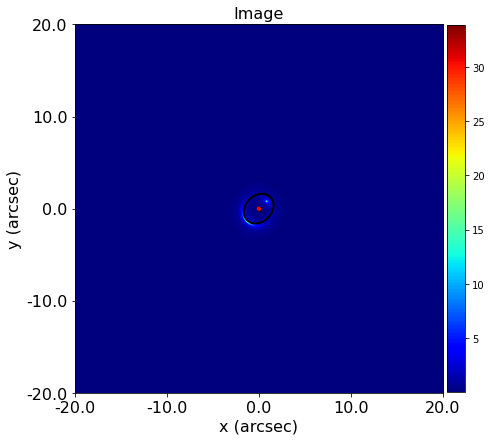

In [9]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures_2d(image=True)

We can now pass this simulator a tracer, which creates the ray-traced image plotted above and simulates it as an
interferometer dataset.

In [10]:
interferometer = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

Lets plot the simulated interferometer dataset before we output it to fits.

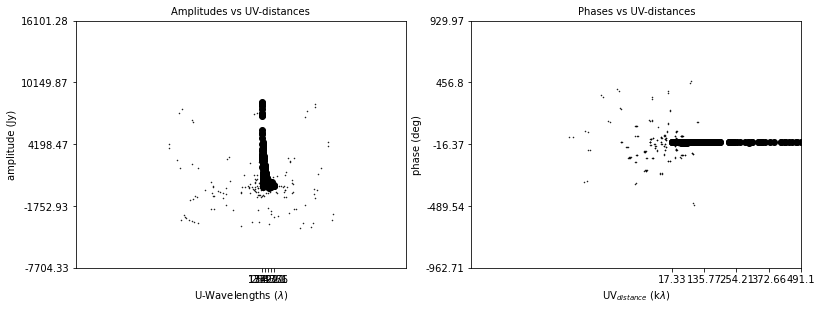

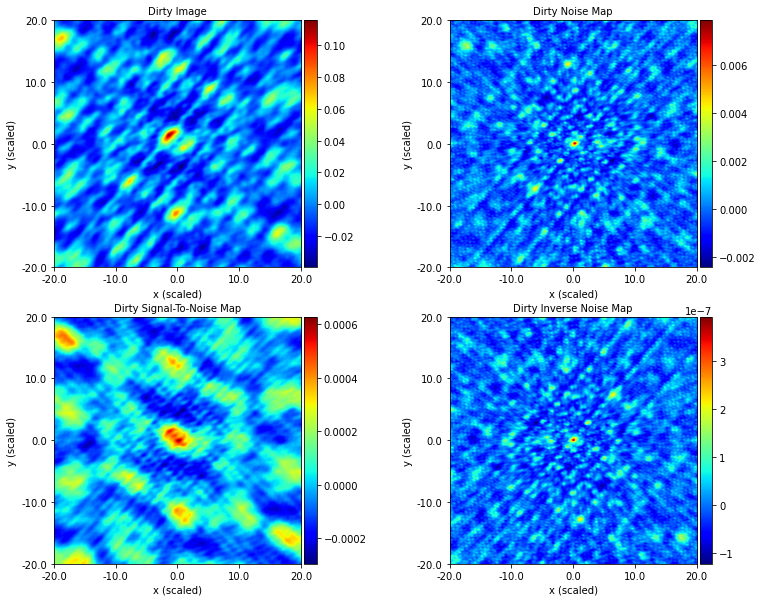

In [11]:
interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()
interferometer_plotter.subplot_dirty_images()

__Output__

Output the simulated dataset to the dataset path as .fits files.

In [12]:
interferometer.output_to_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
    overwrite=True,
)

__Visualize__

Output a subplot of the simulated dataset, the image and the tracer's quantities to the dataset path as .png files.

In [ ]:
mat_plot_2d = aplt.MatPlot2D(output=aplt.Output(path=dataset_path, format="png"))

interferometer_plotter = aplt.InterferometerPlotter(
    interferometer=interferometer, mat_plot_2d=mat_plot_2d
)
interferometer_plotter.subplot_interferometer()
interferometer_plotter.subplot_dirty_images()

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, mat_plot_2d=mat_plot_2d)
tracer_plotter.subplot_tracer()

__Pickles__

Pickle the `Tracer` in the dataset folder, ensuring the true `Tracer` is safely stored and available if we need to 
check how the dataset was simulated in the future. 

This will also be accessible via the `Aggregator` if a model-fit is performed using the dataset.

In [ ]:
tracer.save(file_path=dataset_path, filename="true_tracer")

The dataset can be viewed in the folder `interferometer/instruments/sma`.